<a href="https://colab.research.google.com/github/TAKE-JP-17/Pytorch/blob/main/oscillator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def exact_solution(d, w0, t):
  "Define the analytical solution to the under-damped harmonic oscillator problem above."
  assert d < w0
  w = np.sqrt(w0**2-d**2)
  phi = np.arctan(-d/w)
  A = 1/(2*np.cos(phi))
  cos = torch.cos(phi+w*t)
  exp = torch.exp(-d*t)
  u = exp*2*A*cos
  return u

class FCN(nn.Module):
  "Define a standard fully-connected network in PyTorch"

  def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
    super().__init__()
    activation = nn.Tanh
    self.fcs = nn.Sequential(*[
             nn.Linear(N_INPUT, N_HIDDEN),
             activation()])
    self.fch = nn.Sequential(*[
             nn.Sequential(*[
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()]) for _ in range(N_LAYERS-1)])
    self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

  def forward(self, x):
    x = self.fcs(x)
    x = self.fch(x)
    x = self.fce(x)
    return x

Loss Function

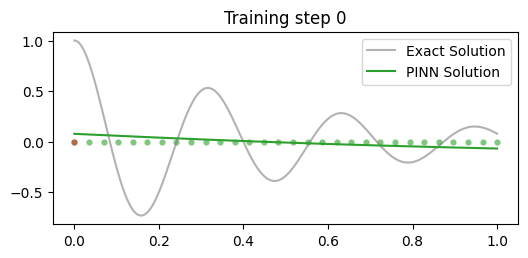

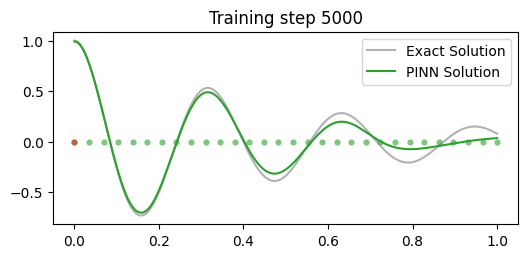

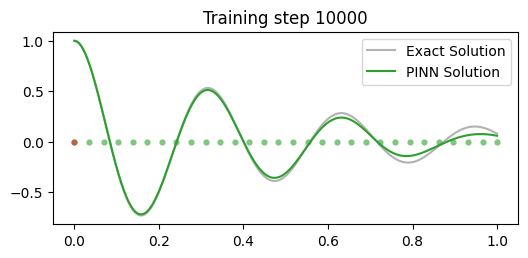

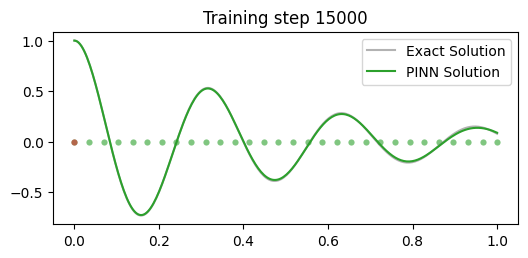

In [14]:
torch.manual_seed(123)

# define a neural network to train
# TODO: write code here
pinn = FCN(1,1,32,3)

# define boundary points, for the boundary loss
# TODO: write code here
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# define training points over the entire domain, for the physics loss
# TODO: write code here
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# train the PINN
d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
for i in range(15001):
  optimizer.zero_grad()

  # compute each term of the PINN loss function above
  # using the following hyperparameters:
  lambda1, lambda2 = 1e-1, 1e-4

  # compute boundary loss
  # TODO: write code here
  u = pinn(t_boundary) # (1,1)
  loss1 = (torch.squeeze(u) - 1)**2

  dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
  loss2 = (torch.squeeze(dudt) - 0)**2

  # compute physics loss
  # TODO: write code here
  u = pinn(t_physics)
  dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
  d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
  loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

  # backpropagate joint loss, take optimizer step
  # TODO: write code here
  loss = loss1 + lambda1*loss2 + lambda2*loss3
  loss.backward()
  optimizer.step()

  # plot the result as training progresses
  if i % 5000 == 0:
    #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
    u = pinn(t_test).detach()
    plt.figure(figsize=(6,2.5))
    plt.scatter(t_physics.detach()[:,0],
                torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
    plt.scatter(t_boundary.detach()[:,0],
                torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
    plt.plot(t_test[:,0], u_exact[:,0], label="Exact Solution", color="tab:grey", alpha=0.6)
    plt.plot(t_test[:,0], u[:,0], label="PINN Solution", color="tab:green")
    plt.title(f"Training step {i}")
    plt.legend()
    plt.show()





True value of mu: 4


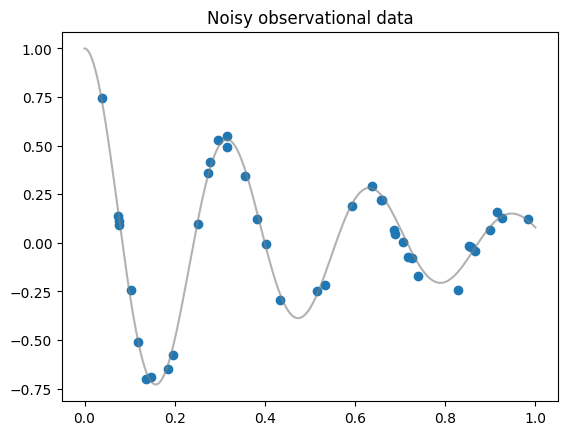

In [15]:
# create some noisy observational data
torch.manual_seed(123)
d, w0 = 2, 20
print(f"True value of mu: {2*d}")
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)

plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
t_test, u_exact = torch.linspace(0,1,300).view(-1,1), exact_solution(d, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact Solution", color="tab:grey", alpha=0.6)
plt.show()

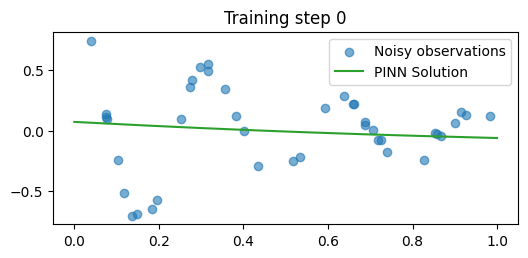

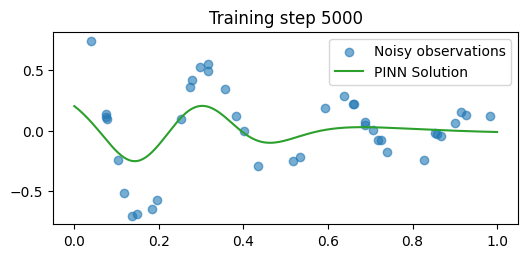

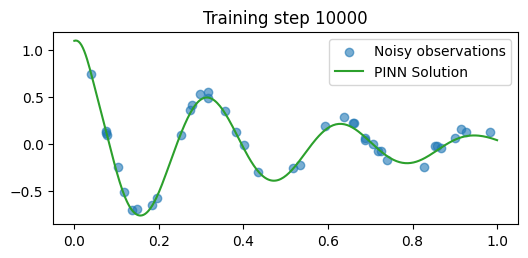

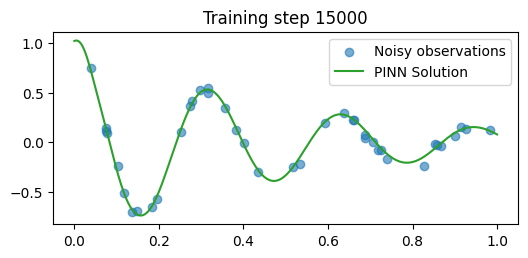

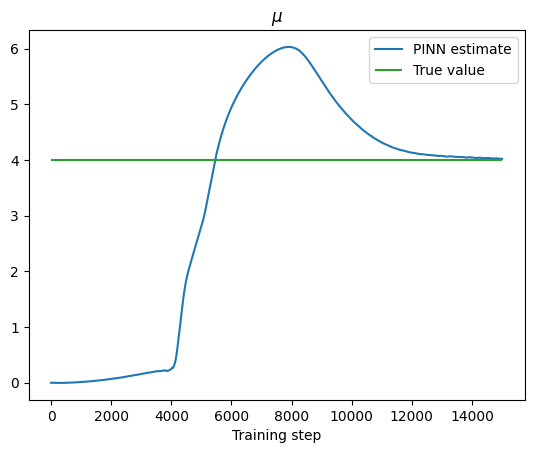

In [19]:
torch.manual_seed(123)

# define a nn to train
pinn = FCN(1,1,32,3)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# train the PINN
d, w0 = 2, 20
_, k = 2*d, w0**2

# treat mu as a learnable parameter
# TODO: write code here
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []

# add mu to the optimizer
# TODO: write code here
optimizer = torch.optim.Adam([mu] + list(pinn.parameters()), lr=1e-3)

for i in range(15001):
  optimizer.zero_grad()

  # compute each term of the PINN loss function above
  # using the following hyperparameters:
  lambda1 = 1e4

  # compute physics loss
  # TODO: write code here
  u = pinn(t_physics)
  dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
  d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
  loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

  # compute data loss
  u = pinn(t_obs)
  loss2 = torch.mean((u - u_obs)**2)

  # backpropagate joint loss, take optimizer step
  # TODO: write code here
  loss = loss1 + lambda1*loss2
  loss.backward()
  optimizer.step()

  # record mu value
  mus.append(mu.item())

  # plot the result as training progresses
  if i % 5000 == 0:
    u = pinn(t_test).detach()
    plt.figure(figsize=(6,2.5))
    plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6)
    plt.plot(t_test[:,0], u[:,0], label="PINN Solution", color="tab:green")
    plt.title(f"Training step {i}")
    plt.legend()
    plt.show()

plt.figure()
plt.title("$\mu$")
plt.plot(mus, label="PINN estimate")
plt.hlines(2*d, 0, len(mus), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()